In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/visual recognition/HW1

/content/drive/MyDrive/Colab Notebooks/visual recognition/HW1


In [1]:
import os
import numpy as np
import sklearn.model_selection as skms
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm

from PIL import Image

# Step 1: Download Data

In [12]:
workspace_dir = '.'

# gdown is a package that downloads files from google drive
!gdown --id 1C63HlTAzOF0F6T5rh8hc8bRSruX0pBZO \
    --output "{workspace_dir}/data.zip"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1C63HlTAzOF0F6T5rh8hc8bRSruX0pBZO
To: /content/data.zip
100% 678M/678M [00:05<00:00, 122MB/s]


##Decompress the dataset

In [13]:
import zipfile
import pathlib


data_dir = 'data'
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Load data


In [2]:
class MyDataset(Dataset):
  def __init__(self , img_dir, label_path , test_mode, transform = None):

    label_data = open(label_path, 'r')
    imgs = []

    for x in label_data:
      x = x.rstrip()
      if not test_mode :
        data = x.split()
        imgs.append((data[0], data[1]))
      else:
        imgs.append(x)
        
    if not test_mode :
      self.img_path = [os.path.join(img_dir,x[0]) for x in imgs]
      self.label = [int(x[1].split(".")[0])-1 for x in imgs]
    else : 
      self.img_path = [os.path.join(img_dir,x) for x in imgs]
      self.label = [int(x[0].split(".")[0]) for x in imgs]

    self.transform = transform

  def __getitem__(self,index):
    img_path = self.img_path[index]
    label = self.label[index]
    img = Image.open(img_path).convert("RGB")
    

    if self.transform is not None:
      img = self.transform(img)
    return img,label

  def __len__(self):
    return len(self.img_path)


In [3]:
def pad(img, fill=0, size_max=500):
    """
    Pads images to the specified size (height x width). 
    Fills up the padded area with value(s) passed to the `fill` parameter. 
    """
    pad_height = max(0, size_max - img.height)
    pad_width = max(0, size_max - img.width)
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)

In [4]:
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))
max_padding = transforms.Lambda(lambda x: pad(x, fill=fill))

train_transform = transforms.Compose([max_padding,
                    transforms.RandomOrder([                                                            transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomCrop((375, 375))]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([max_padding,
                    transforms.CenterCrop((375, 375)),                     
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])])

In [15]:
batch_size = 24
train_dir = 'data/training_images'
test_dir = 'data/testing_images'
train_label_path = 'data/training_labels.txt'
test_label = 'data/testing_img_order.txt'
test_mode = False

img_dir = train_dir
label_path = train_label_path


full_dataset = MyDataset(img_dir = train_dir,
            label_path = train_label_path ,
            test_mode = False,
            transform = train_transform)

test_datasets = MyDataset(img_dir = test_dir,
              label_path = test_label,
              test_mode = True,
              transform = test_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_datasets, valid_datasets = torch.utils.data.random_split(full_dataset, [train_size, test_size])

with open('data/classes.txt') as f:
  class_data = [ x.strip() for x in f.readlines()]


In [19]:
## caculate the average size of image
dataset = full_dataset
ds = dataset.img_path
shapes = []

for path in ds:
  images = Image.open(path).convert("RGB")
  shapes.append([images.height,images.width])
heights, widths = [[h for h,_ in shapes], [w for _,w in shapes]]
print('Average sizes:', *map(np.median, zip(*shapes)))

Average sizes: 375.0 500.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data/training_images/2796.jpg
2
003.Sooty_Albatross


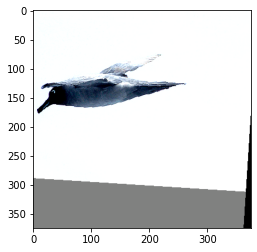

In [20]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

index = 599
dataset = full_dataset
img,label = dataset.__getitem__(index)
imshow(img)
print(dataset.img_path[index])
print(label)
print(class_data[label])

In [21]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=batch_size, shuffle=False, num_workers=2)  
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=False, num_workers=2)    

In [22]:
print(len(train_datasets))
print(len(valid_datasets))
print(len(test_datasets))

2400
600
3033


In [23]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

100
25
127


In [24]:
for batch_idx, data in enumerate(valid_loader):
  img, label = data
  print(img[0].size())
  break

torch.Size([3, 375, 375])


# Load Pretrain Model

In [25]:
model_name = 'resnet10.pth'

if os.path.isfile(model_name):
  model = models.resnet50(pretrained = False)
  fc_features = model.fc.in_features 
  model.fc = nn.Linear(fc_features, len(class_data))
  model.load_state_dict(torch.load(model_name))
  print("old")
else :
  # Load model
  model = models.resnet50(pretrained = True)
  #for param in model.parameters():
  #  param.requires_grad = False
  fc_features = model.fc.in_features 
  model.fc = nn.Linear(fc_features, len(class_data))
  print("new")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

new


## Chech GPU


In [26]:
device = torch.device("cuda")
if torch.cuda.is_available():
  model = model.to(device)
  print("Success")

Success


In [27]:
def train(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler ):
  valid_loss_min = np.Inf

  for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch:{}'.format(epoch))

    #train the model
    for data in tqdm(train_loader):
      img, label = data
      img, label = img.cuda(), label.cuda()

      #Forward propagation 
      optimizer.zero_grad()
      output = model(img)
      loss = criterion(output,label)

      #Back propagation & update weights 
      loss.backward()
      optimizer.step()

      train_loss += loss.item()*img.size(0)

    #validata the model
    model.eval()
    with torch.no_grad():
      for data in tqdm(val_loader):
        img, label = data
        img,label = img.cuda(), label.cuda()

        output = model(img)
        loss = criterion(output,label)
        valid_loss += loss.item()*img.size(0)

      #calculate average losses
      train_loss = train_loss/len(train_loader.dataset)
      valid_loss = valid_loss/len(val_loader.dataset)

      print('\tTraining loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))

      #save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(),model_name)
        valid_loss_min = valid_loss

    scheduler.step()

In [28]:
def test(model, valid_loader, criterion):

  test_loss = 0.
  correct = 0.
  total = 0.

  model.eval()
  with torch.no_grad():
    for batch_idx, data in enumerate(valid_loader):
      img, label = data
      img,label = img.cuda(), label.cuda()
      output = model(img)
      loss = criterion(output, label)
      test_loss = test_loss + ((1 / (batch_idx + 1))*(loss.data - test_loss))
      pred = torch.max(output,1).indices
      correct += torch.sum (label == pred)
      total += img.size(0)
 
  print('Test Loss: {:.6f}'.format(test_loss))

  print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [ ]:
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
train(model, train_loader, valid_loader, epochs, criterion, optimizer, scheduler)

running epoch:1


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


	Training loss: 0.123434 	Validation Loss: 1.785119
Validation loss decreased (inf --> 1.785119). Saving model...
running epoch:2


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


	Training loss: 0.121567 	Validation Loss: 1.681372
Validation loss decreased (1.785119 --> 1.681372). Saving model...
running epoch:3


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


	Training loss: 0.071622 	Validation Loss: 1.432514
Validation loss decreased (1.681372 --> 1.432514). Saving model...
running epoch:4


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


	Training loss: 0.047046 	Validation Loss: 1.279922
Validation loss decreased (1.432514 --> 1.279922). Saving model...
running epoch:5


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


	Training loss: 0.045717 	Validation Loss: 1.429797
running epoch:6


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


	Training loss: 0.041979 	Validation Loss: 1.314798
running epoch:7


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


	Training loss: 0.045447 	Validation Loss: 1.671375
running epoch:8


 93%|█████████▎| 93/100 [02:36<00:11,  1.67s/it]

In [ ]:
criterion = nn.CrossEntropyLoss()
test(model, valid_loader, criterion)

# submission


In [29]:
def submission(model, datasets, loader):
  model.eval()
  
  with torch.no_grad():
    submission = []
    index = 0
    for data in tqdm(loader):
      img, label = data
      img = img.cuda()

      output = model(img) # the predicted category 
      predicted_class=torch.max(output,1).indices

      for i in range(len(predicted_class)):
        img_path = datasets.img_path[index * batch_size + i].split("/")[1]
        submission.append([img_path, str(class_data[int(predicted_class[i])])])

      index += 1

  np.savetxt('answer.txt', submission, fmt='%s')

In [30]:
submission(model, test_datasets, test_loader)

100%|██████████| 127/127 [00:30<00:00,  4.19it/s]
